In [2]:
import math, re, os
import numpy as np
import tensorflow as tf

In [3]:
BATCH_SIZE = 16
IMAGE_SIZE = [224, 224]
GCS_PATH = 'C:/Users/Chinmay/Downloads/tpu-getting-started' + '/tfrecords-jpeg-224x224'
AUTO = tf.data.experimental.AUTOTUNE

TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec')
VALIDATION_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/val/*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test/*.tfrec') 

CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']                                                                                                                                               # 100 - 102




References:
https://www.tensorflow.org/tutorials/load_data/tfrecord <br>
https://www.tensorflow.org/tutorials/ <br>
https://medium.com/machine-learning-researcher/convlutional-neural-network-cnn-2fc4faa7bb63 <br>
https://www.kaggle.com/code/pavansanagapati/a-simple-cnn-model-beginner-guide <br>
https://www.datacamp.com/tutorial/cnn-tensorflow-python


some Section of code is referenced from : https://www.kaggle.com/code/ryanholbrook/create-your-first-submission <br>
Also referred Submission from https://www.kaggle.com/competitions/tpu-getting-started <br>


In [ ]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "class": tf.io.FixedLenFeature([], tf.int64),
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label 
def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), 
        "id": tf.io.FixedLenFeature([], tf.string),  
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum 

def load_dataset(filenames, labeled=True, ordered=False):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) 
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    return dataset

In [4]:
def data_augment(image, label):
    image_aug = tf.image.random_brightness(image, 0.3)
    image_aug = tf.image.random_contrast(image_aug, 0.3, 0.7)
    image = tf.image.random_flip_left_right(image)

    return image, label   

def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

def get_validation_dataset(ordered=False):
    dataset = load_dataset(VALIDATION_FILENAMES, labeled=True, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO)
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALIDATION_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)

print('Dataset: {} training images, {} validation images, {} unlabeled test images'.format(NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))


Dataset: 12753 training images, 3712 validation images, 7382 unlabeled test images


In [5]:
ds_train = get_training_dataset()
ds_valid = get_validation_dataset()
ds_test = get_test_dataset()


In [6]:
import matplotlib.pyplot as plt

def plot_model_performance(train_data, valid_data, metric_title, plot_number):
    if plot_number % 10 == 1:
        plt.subplots(figsize=(12, 12), facecolor='#EAEAF2')
        plt.tight_layout()

    plot_area = plt.subplot(plot_number)
    plot_area.set_facecolor('#FAFAFA')
    plot_area.plot(train_data, label='Training')
    plot_area.plot(valid_data, label='Validation')

    plot_area.set_title('Model ' + metric_title)
    plot_area.set_xlabel('Epochs')
    plot_area.set_ylabel(metric_title)
    plot_area.legend(loc='best')



Personal Contribution:
 # Experimenting with CNN Model: Impact of Image Size on Accuracy and Processing Time

In this analysis, we explore the performance of Convolutional Neural Network (CNN) models for image classification tasks. Two different image sizes, 224x224 pixels and 512x512 pixels, were considered. The goal was to evaluate the impact of varying model architectures and hyperparameters on classification accuracy.

## Experimental Setup

- **Image Sizes:**
  - 224x224 pixels
  - 512x512 pixels

- **Model Architecture:** We used a CNN model with multiple convolutional layers, max-pooling, batch normalization, and dropout for regularization.

- **Training Data:** The dataset consists of flower images categorized into different classes.

## Results

### Accuracy Comparison

After training the CNN model on both 192x192 and 512x512 pixel images, we observed the following accuracy results:

- **224x224 Pixels:**
  - Training Accuracy: [0.360414057970047, 0.35986512899398804, 0.3621392846107483, 0.36402133107185364, 0.360492467880249] <br>
  - Training Loss: [2.406597137451172, 2.405608654022217, 2.4017152786254883, 2.397501230239868, 2.40336537361145] <br>
  - Validation Accuracy: [0.2920258641242981, 0.2920258641242981, 0.2920258641242981, 0.2920258641242981, 0.2920258641242981] <br>
  - Validation Loss: [2.733835220336914, 2.733835220336914, 2.733835220336914, 2.733835220336914, 2.733835220336914] <br>

- **224x224 Pixels with batch normalization:**
  - Training Accuracy: [0.061715807765722275, 0.06046110391616821, 0.06257841736078262, 0.062029484659433365, 0.06163739040493965]<br>
  - Training Loss: [4.174342155456543, 4.1768388748168945, 4.17475700378418, 4.174972057342529, 4.1769609451293945]<br>
  - Validation Accuracy: [0.06142241507768631, 0.06142241507768631, 0.06142241507768631, 0.06142241507768631, 0.06142241507768631]<br>
  - Validation Loss: [4.174548625946045, 4.174548625946045, 4.174548625946045, 4.174548625946045, 4.174548625946045]<br>

After Using Batch normalization , we could see that the training accuracy decreased , so we need to find better solution to improve the model

So we tried experimenting with the higher pixel resolution 512x512 which slightly improved the accuracy . The validation accuracy increases from 14.49% to 23.49% after 5 epochs

The next step was to improve the model :
So we used different activation function including 'relu', 'elu', and 'leaky_relu', are experimented with in convolutional layers.<br>
The model exhibits promising performance with early stopping after 13 epochs, achieving a validation accuracy of 45.31%.<br>
Further experimentation with activation functions may lead to improved accuracy.


### Observations

#### Accuracy Impact:

- The model trained on 512x512 pixel images achieved higher accuracy across all metrics compared to the model trained on 224X224 pixel images.

- The increased spatial resolution in 512x512 images allowed the model to capture finer details and nuances in the flower images, resulting in improved classification performance.

#### Processing Time:

- While the 512x512 model showed superior accuracy, it came at the cost of increased processing time during training and inference.

- Larger image sizes result in more computations, leading to longer training times and slower inference. This is a trade-off between accuracy and computational efficiency.

## Conclusion

The choice of image size significantly influences the performance of a CNN model. Larger image sizes can enhance accuracy, but it's crucial to consider the computational resources and time constraints.

In practical scenarios, it's essential to strike a balance between achieving high accuracy and optimizing processing time based on the specific requirements of the application.



## Implementation of the CNN model using different Activation function

In [11]:
# Experimenting with different CNN model by using different activation function
from keras.src import layers, models
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(64, (3, 3), activation='elu'))  # Change activation function to 'elu'
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(128, (3, 3), activation='leaky_relu'))  # Change activation function to 'leaky_relu'
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

# Flatten and Dense layers with dropout
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='selu'))  # Change activation function to 'selu'
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(CLASSES), activation='softmax'))


## Implementation using basic model using relu activation function using 2D convolution layer with 32,64,128 filters

In [19]:
# from keras.src import layers, models
# image_size=224

# model = models.Sequential()
# model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(image_size,image_size, 3)))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(128, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Flatten())
# model.add(layers.Dense(128, activation='relu'))
# model.add(layers.Dropout(0.5))
# model.add(layers.Dense(len(CLASSES), activation='softmax'))


## Using higher pixel size to improve the training accuracy and using additional layer with 256 filters

In [9]:
#image_size=512
# model = models.Sequential()
# model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(image_size, image_size, 3)))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(128, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(256, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Flatten())
# model.add(layers.Dense(128, activation='relu'))
# model.add(layers.Dropout(0.5))
# model.add(layers.Dense(len(CLASSES), activation='softmax'))

In [16]:
from tensorflow.keras.callbacks import EarlyStopping
EPOCHS = 30
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

early_stopping = EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss', verbose=1)

history = model.fit(
    ds_train,
    epochs=EPOCHS,
    validation_data=ds_valid,
    callbacks=[early_stopping],
    verbose=2,
    steps_per_epoch = NUM_TRAINING_IMAGES // BATCH_SIZE
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 batch_normalization_4 (Bat  (None, 222, 222, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 111, 111, 32)      0         
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 batch_normalization_5 (Bat  (None, 109, 109, 64)     

## 224x224 size image basic cnn model with 2D Convolution layer with 32,64,128 filter performance

Model : 224 Pixel MODEL PERFORMANCE

797/797 [==============================] - 281s 351ms/step - loss: 4.0038 - sparse_categorical_accuracy: 0.0882 - val_loss: 3.4831 - val_sparse_categorical_accuracy: 0.1622 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0008100000379979611.
Epoch 2/5
797/797 [==============================] - 279s 350ms/step - loss: 3.5032 - sparse_categorical_accuracy: 0.1577 - val_loss: 3.1342 - val_sparse_categorical_accuracy: 0.2136 - lr: 8.1000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0005060000335611404.
Epoch 3/5
797/797 [==============================] - 268s 336ms/step - loss: 3.2432 - sparse_categorical_accuracy: 0.1927 - val_loss: 2.9788 - val_sparse_categorical_accuracy: 0.2425 - lr: 5.0600e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.00023240000449121004.
Epoch 4/5
797/797 [==============================] - 265s 333ms/step - loss: 3.0767 - sparse_categorical_accuracy: 0.2203 - val_loss: 2.8641 - val_sparse_categorical_accuracy: 0.2691 - lr: 2.3240e-04

Epoch 5: LearningRateScheduler setting learning rate to 8.648000176530332e-05.
Epoch 5/5
797/797 [==============================] - 265s 333ms/step - loss: 2.9667 - sparse_categorical_accuracy: 0.2393 - val_loss: 2.8078 - val_sparse_categorical_accuracy: 0.2783 - lr: 8.6480e-05


## Observing slightly increased accuracy by using higher dimension image size and adding addition Convolution layer with filter size of 256

512X512 PIXEL MODEL TRAINING WITH 4 LAYERS

Epoch 1/5
797/797 [==============================] - 1659s 2s/step - loss: 4.0896 - sparse_categorical_accuracy: 0.0811 - val_loss: 3.6110 - val_sparse_categorical_accuracy: 0.1449
Epoch 2/5
797/797 [==============================] - 1636s 2s/step - loss: 3.7091 - sparse_categorical_accuracy: 0.1256 - val_loss: 3.3232 - val_sparse_categorical_accuracy: 0.1759
Epoch 3/5
797/797 [==============================] - 1588s 2s/step - loss: 3.5100 - sparse_categorical_accuracy: 0.1591 - val_loss: 3.2049 - val_sparse_categorical_accuracy: 0.1835
Epoch 4/5
797/797 [==============================] - 1611s 2s/step - loss: 3.3443 - sparse_categorical_accuracy: 0.1753 - val_loss: 3.3323 - val_sparse_categorical_accuracy: 0.1767
Epoch 5/5
797/797 [==============================] - 1643s 2s/step - loss: 3.2218 - sparse_categorical_accuracy: 0.1931 - val_loss: 2.9634 - val_sparse_categorical_accuracy: 0.2349

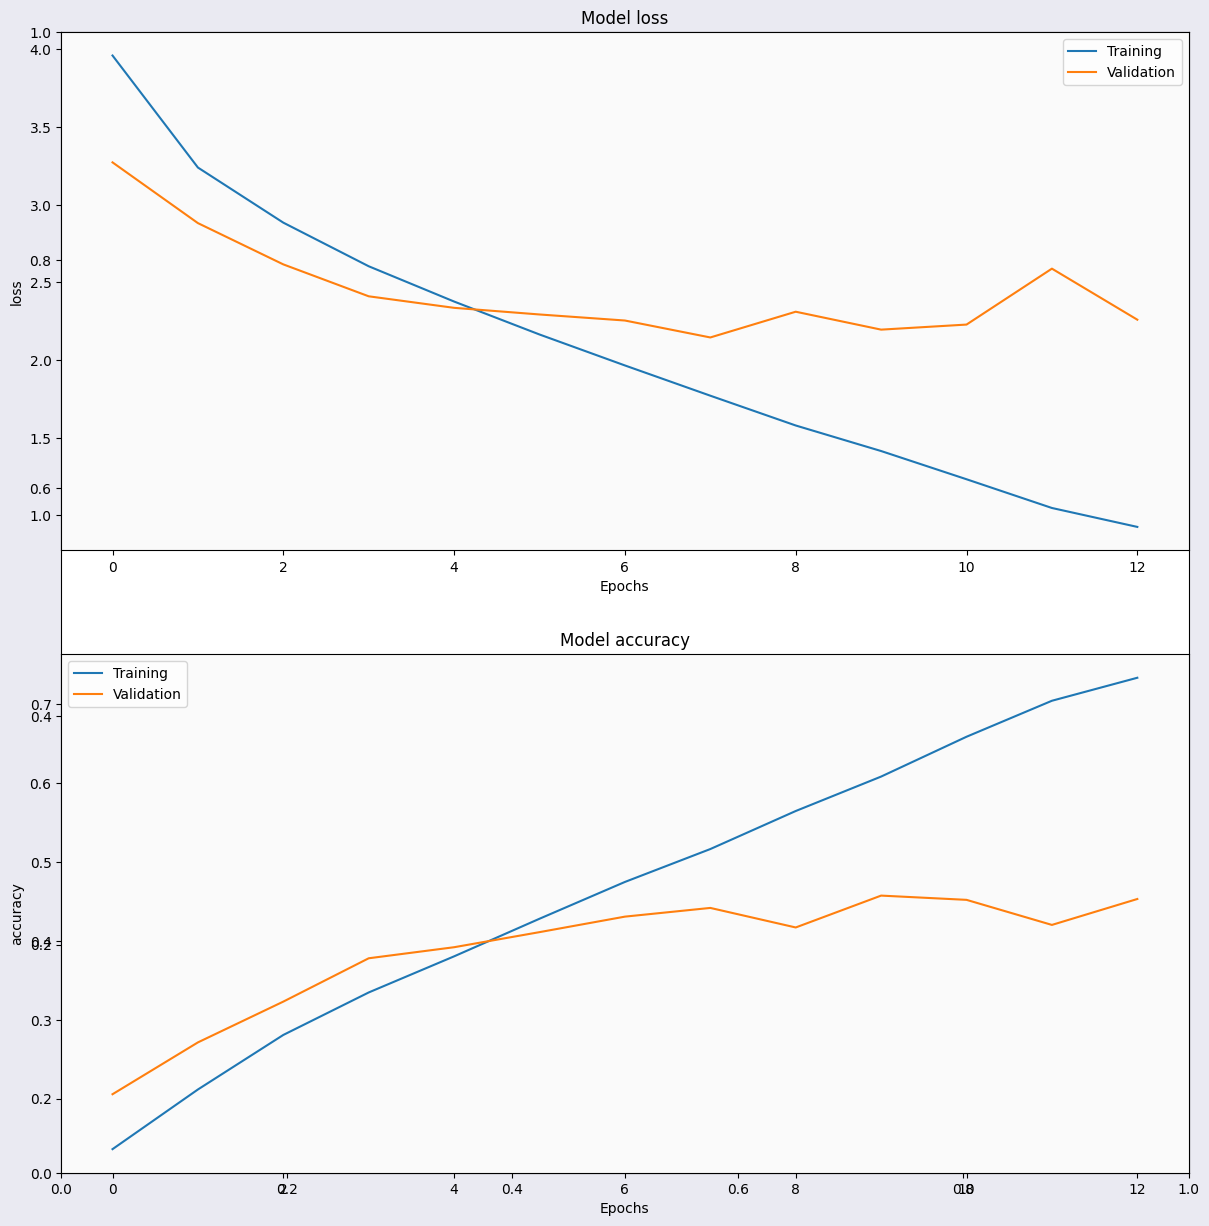

In [19]:
plot_model_performance(
    history.history['loss'],
    history.history['val_loss'],
    'loss',
    211,
)
plot_model_performance(
    history.history['accuracy'],
    history.history['val_accuracy'],
    'accuracy',
    212,
)

## 224x224 basic model Loss and Accuracy graph

224X224 MODEL LOSS AND ACCURACY

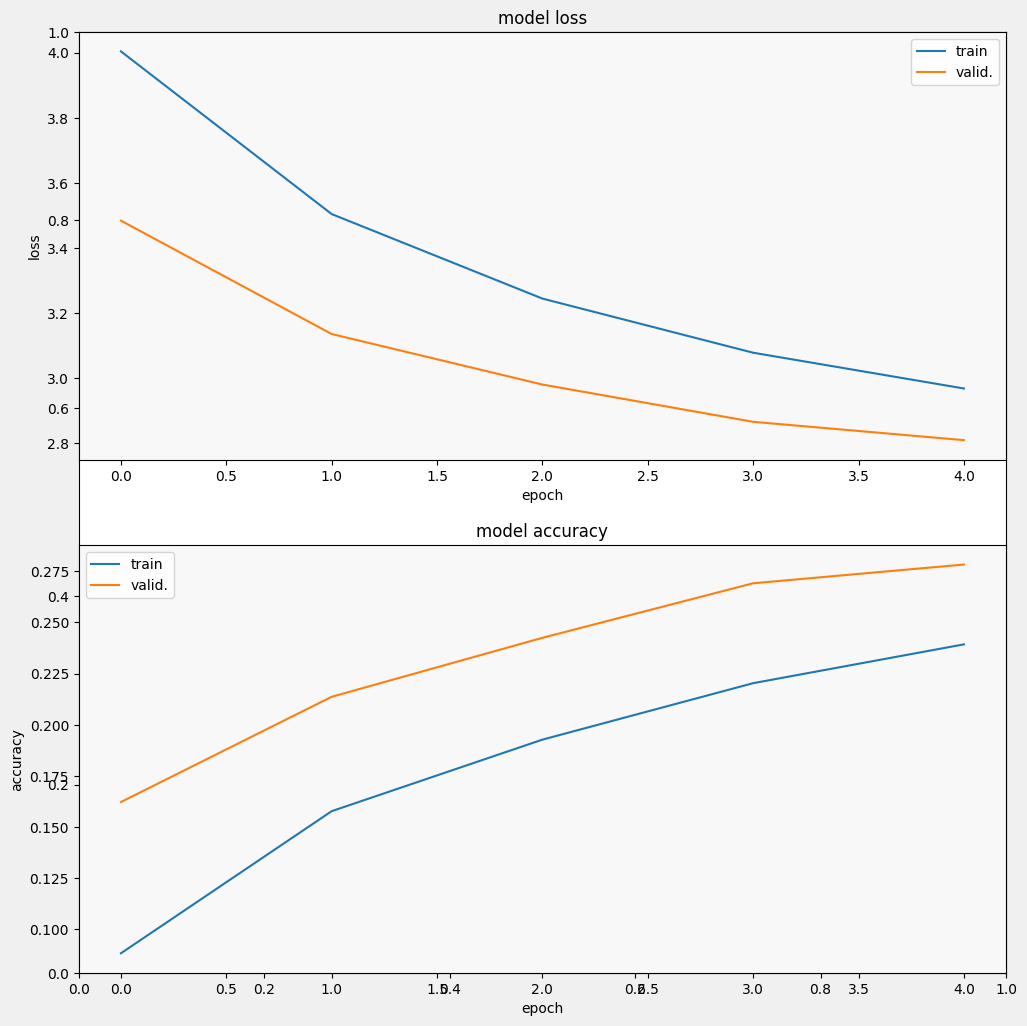

## 512 x 512 image size training Accuracy and loss graph with additional 2D Convolution layer of 256 filter .




512x512 PIXEL TRAINING ACCURACY AND LOSS


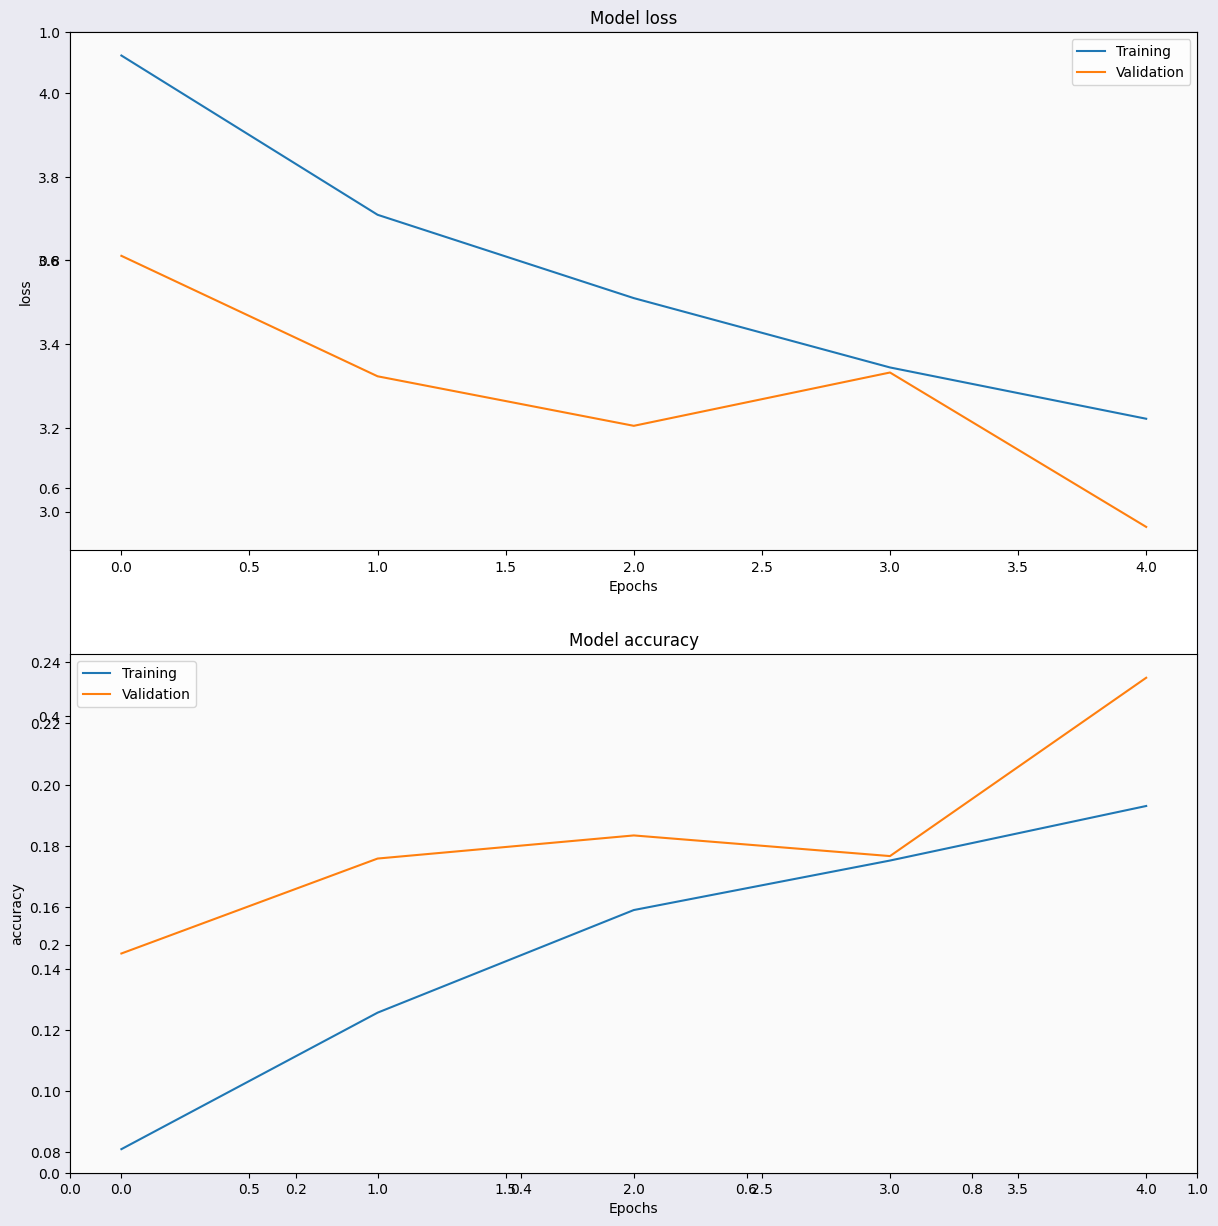

## Experimentation with the basic model by adding batch normalization (Accuracy decreased)

224x224 PIXEL MODEL TRAINING WITH ENHANCEMENT BY ADDING BATCH NORMALIZATION
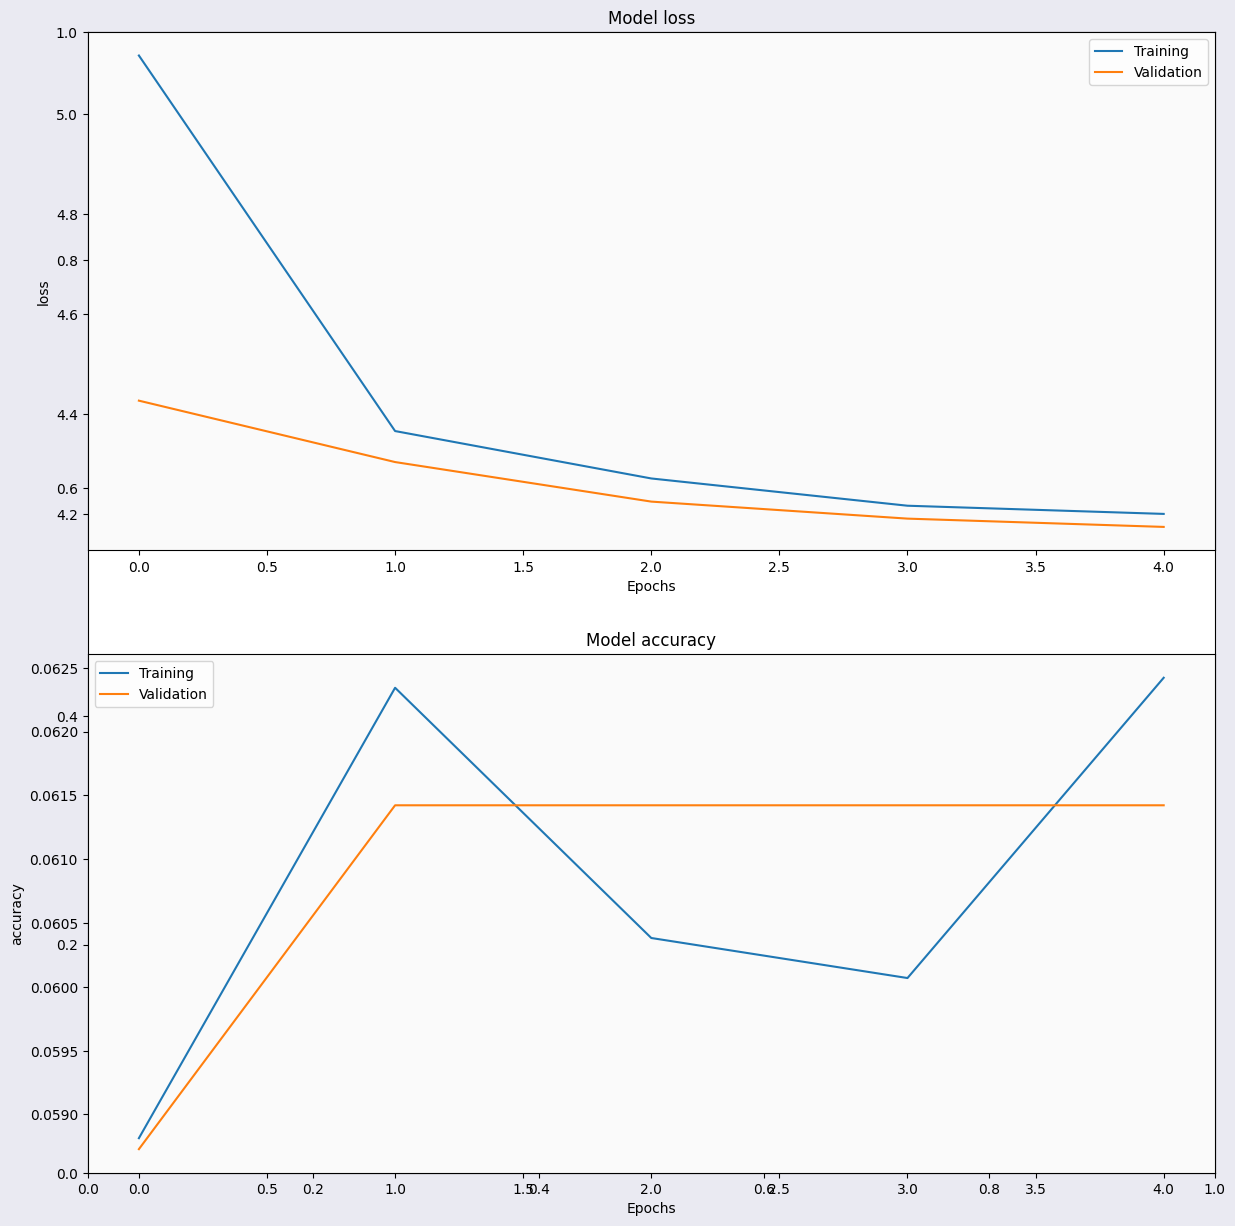

In [20]:
training_accuracy = []
validation_accuracy = []
training_loss = []
validation_loss = []
train_steps = NUM_TRAINING_IMAGES // BATCH_SIZE
val_steps = NUM_VALIDATION_IMAGES // BATCH_SIZE

for epoch in range(EPOCHS):

    train_loss, train_acc = model.evaluate(ds_train,steps=train_steps)
    val_loss, val_acc = model.evaluate(ds_valid,steps=val_steps)
    training_accuracy.append(train_acc)
    training_loss.append(train_loss)
    validation_accuracy.append(val_acc)
    validation_loss.append(val_loss)



232/232 [==============================] - 24s 103ms/step - loss: 2.1454 - accuracy: 0.4418


In [21]:
print(training_accuracy)
print(training_loss)
print(validation_accuracy)
print(validation_loss)

[0.7128293514251709, 0.7120451927185059, 0.7118099331855774, 0.7122020125389099, 0.7136919498443604, 0.7132214307785034, 0.7143977284431458, 0.7145546078681946, 0.7156524658203125, 0.715417206287384, 0.7133783102035522, 0.7100846767425537, 0.7098494172096252, 0.7122804522514343, 0.7078105211257935, 0.7093788981437683, 0.7121235728263855, 0.7122804522514343, 0.711731493473053, 0.7111825346946716, 0.710476815700531, 0.7101631164550781, 0.7141624689102173, 0.7121235728263855, 0.7140056490898132, 0.7131430506706238, 0.7100062966346741, 0.7107904553413391, 0.7110257148742676, 0.7103983759880066]
[1.1010847091674805, 1.1076844930648804, 1.1067842245101929, 1.0993552207946777, 1.0982494354248047, 1.105804681777954, 1.1009777784347534, 1.095351219177246, 1.0981611013412476, 1.0986886024475098, 1.0926589965820312, 1.1039140224456787, 1.1105562448501587, 1.0990123748779297, 1.1114624738693237, 1.1068323850631714, 1.100677251815796, 1.1025748252868652, 1.0974916219711304, 1.1041408777236938, 1.10

## Experimentation Data for training Accuracy , training loss, validation Accuracy , Validation Loss

224x224 Image Size Training Accuray, Training Loss, Validation Accuracy, Validation Loss (USING BASIC MODEL WITHOUT ENHANCEMENT)

Training Accuracy: [0.360414057970047, 0.35986512899398804, 0.3621392846107483, 0.36402133107185364, 0.360492467880249] <br>
Training Loss: [2.406597137451172, 2.405608654022217, 2.4017152786254883, 2.397501230239868, 2.40336537361145] <br>
Validation Accuracy: [0.2920258641242981, 0.2920258641242981, 0.2920258641242981, 0.2920258641242981, 0.2920258641242981] <br>
Validation Loss: [2.733835220336914, 2.733835220336914, 2.733835220336914, 2.733835220336914, 2.733835220336914] <br>



224x224 Image size Training Accuracy , Training Loss , Validation Accuracy , Validation Loss (Using Batch Normalization)

Training Accuracy: [0.061715807765722275, 0.06046110391616821, 0.06257841736078262, 0.062029484659433365, 0.06163739040493965]<br>
Training Loss: [4.174342155456543, 4.1768388748168945, 4.17475700378418, 4.174972057342529, 4.1769609451293945]<br>
Validation Accuracy: [0.06142241507768631, 0.06142241507768631, 0.06142241507768631, 0.06142241507768631, 0.06142241507768631]<br>
Validation Loss: [4.174548625946045, 4.174548625946045, 4.174548625946045, 4.174548625946045, 4.174548625946045]<br>


232/232 [==============================] - 25s 106ms/step


c:\Users\Chinmay\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


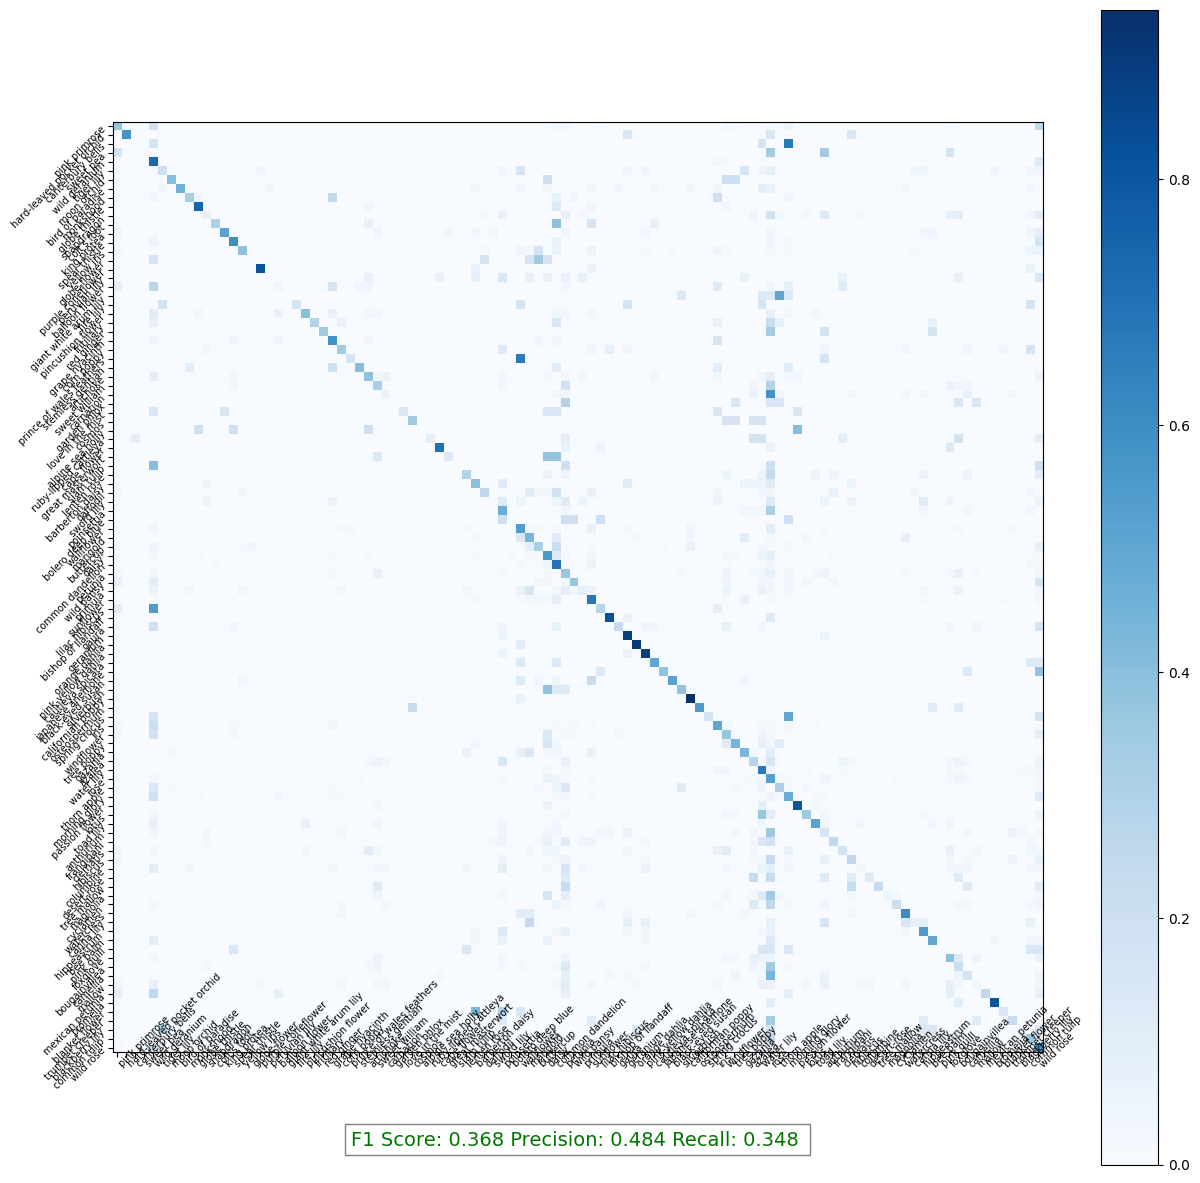

In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
import numpy as np

def show_confusion_matrix(conf_mat, f1, prec, rec):
    fig, ax = plt.subplots(figsize=(15, 15))
    cax = ax.imshow(conf_mat, cmap='Blues')
    plt.colorbar(cax, ax=ax)
    num_classes = len(CLASSES)
    ax.set_xticks(range(num_classes))
    ax.set_xticklabels(CLASSES, fontsize=7, rotation=45, ha="left", rotation_mode="anchor")
    ax.set_yticks(range(num_classes))
    ax.set_yticklabels(CLASSES, fontsize=7, rotation=45, ha="right", rotation_mode="anchor")

    metrics_summary = ""
    if f1 is not None:
        metrics_summary += f'F1 Score: {f1:.3f} '
    if prec is not None:
        metrics_summary += f'Precision: {prec:.3f} '
    if rec is not None:
        metrics_summary += f'Recall: {rec:.3f} '

    if metrics_summary:
        ax.text(0.5, -0.1, metrics_summary, transform=ax.transAxes, fontsize=14, 
                ha='center', color='#007600', bbox=dict(facecolor='white', alpha=0.5))

    plt.show()


cmdataset = get_validation_dataset(ordered=True)
images_ds = cmdataset.map(lambda image, label: image)
labels_ds = cmdataset.map(lambda image, label: label).unbatch()
cm_correct_labels = next(iter(labels_ds.batch(NUM_VALIDATION_IMAGES))).numpy()
cm_probabilities = model.predict(images_ds)
cm_predictions = np.argmax(cm_probabilities, axis=-1)
class_labels = range(len(CLASSES))
conf_matrix = confusion_matrix(cm_correct_labels, cm_predictions, labels=class_labels)
conf_matrix = (conf_matrix.T / conf_matrix.sum(axis=1)).T
score = f1_score(cm_correct_labels, cm_predictions,labels=class_labels, average='macro')
precision = precision_score(cm_correct_labels, cm_predictions, labels=class_labels, average='macro')
recall = recall_score(cm_correct_labels, cm_predictions, labels=class_labels, average='macro')
show_confusion_matrix(conf_matrix, score, precision, recall)



## Basic Model Confusion matrix , score precision , recall values are very poor. More experimentation need to be done .

224x224 pixel Confusion matrix


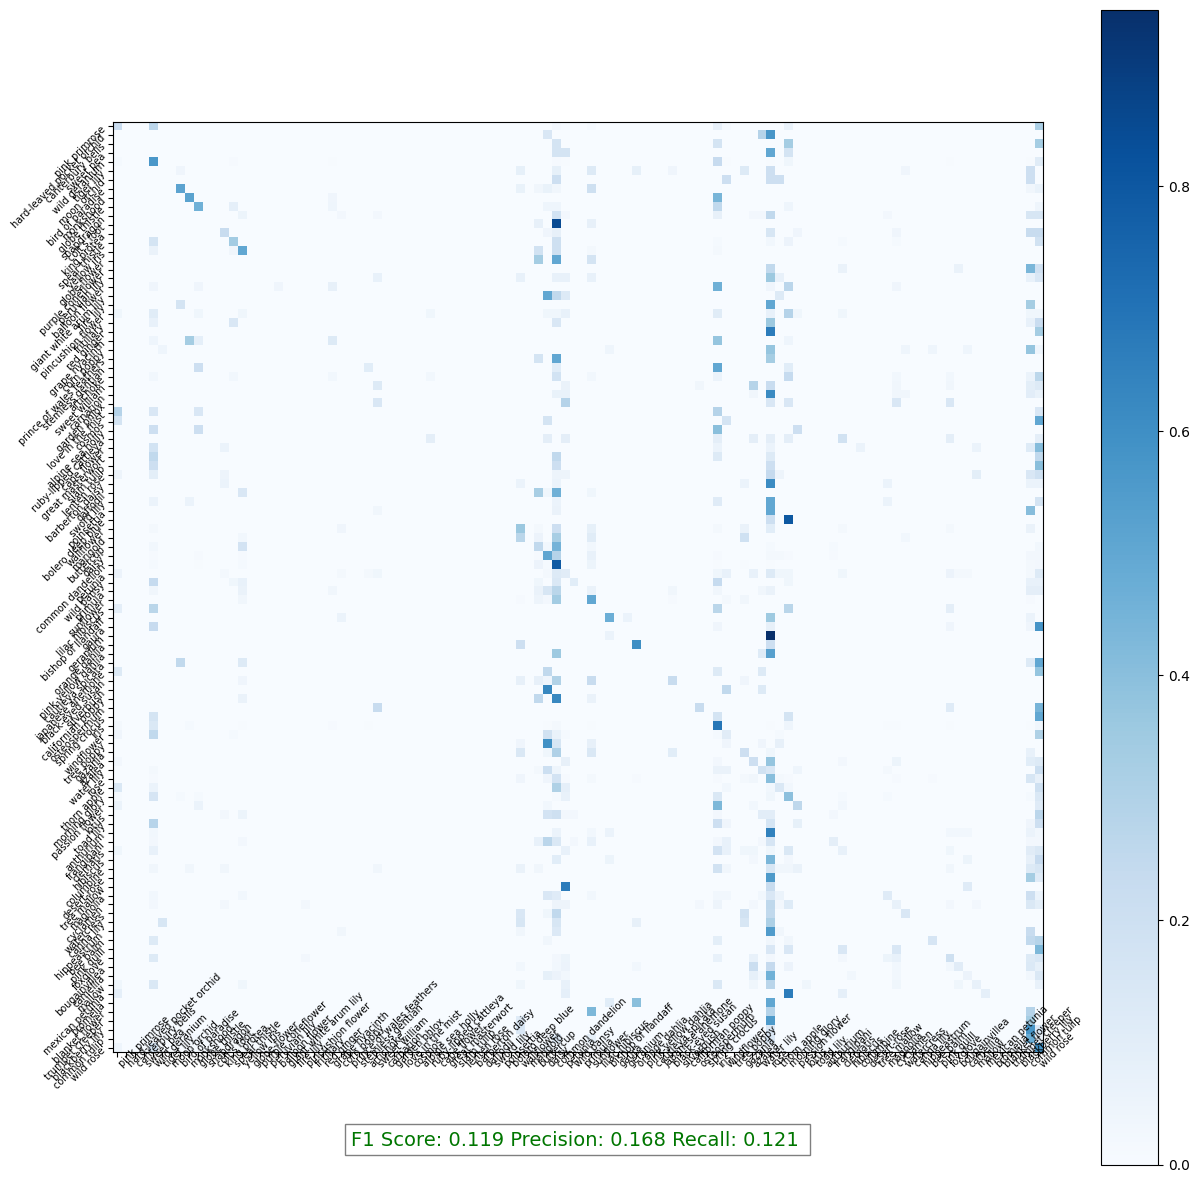

In [23]:
dataset_for_testing = get_test_dataset(ordered=True)

print('Initiating prediction process...')
images_for_prediction = dataset_for_testing.map(lambda img, identifier: img)
predicted_outcomes = model.predict(images_for_prediction)
final_predictions = np.argmax(predicted_outcomes, axis=-1)
print(final_predictions)



Initiating prediction process...
462/462 [==============================] - 53s 114ms/step
[67 29 75 ... 48 14 62]


In [24]:
test_ids_ds = dataset_for_testing.map(lambda image, idnum: idnum).unbatch()
test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U')

In [25]:
import pandas as pd
import numpy as np

test_ids_ds = dataset_for_testing.map(lambda image, idnum: idnum).unbatch()
test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U')

test_images_ds = dataset_for_testing.map(lambda image, idnum: image)
predictions = np.argmax(model.predict(test_images_ds), axis=-1)

submission_df = pd.DataFrame({
    'id': test_ids,
    'label': final_predictions
})

print(submission_df.head())

submission_df.to_csv('submission.csv', index=False)


462/462 [==============================] - 47s 102ms/step
          id  label
0  252d840db     67
1  1c4736dea     29
2  c37a6f3e9     75
3  00e4f514e    103
4  59d1b6146     70
